# Introduction
This notebook provides a gentle introduction to the *glikonal* library. The library is built on top of the *pykonal* solver. As a result the names of some variables might not reflect their meaning in the gliding context.
to facilitate the reading of the code we provide a small translation table between the *pykonal* terminology and the corresponding gliding concepts
1. velocity $\mapsto$ glide ratio
2. traveltime $\mapsto$ altitude


This notebook only contains simple examples with artificial data.

In [1]:
# Import modules.
import numpy as np
import matplotlib.pyplot as plt
#import pykonal
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import glikonal

In [2]:
def euclidean_distance_matrix(src_x,src_y,H,W,hx,hy):
    dist_mat=np.zeros([W,H])
    for x in range(W):
        for y in range(H):
            dist_mat[x,y]=np.sqrt(hx**2*(x-src_x)**2+hy**2*(y-src_y)**2)
    return dist_mat

# No terrain
We start by finding the classical gliding cone, in the case without obstacles.
Hence we set the elevation of all points in the grid to zero.

In [3]:
#set the grid parameters
H=100 #height, or number fo points in the y direction
W=100 #width, or number of points in the x direction
hx=1 #spacing between two neighbouring points along the x axis (taken to be 1m)
hy=1 #spacing between two neighbouring points along the y axis (taken to be 1m)

origin_coords=(0,0,0)
# Instantiate the solver
solver = glikonal.EikonalSolver(coord_sys="cartesian")
#setting the origin (not important)
solver.velocity.min_coords = origin_coords
solver.elevation.min_coords = origin_coords

# Set the interval between nodes of the computational grid.
# For Cartesian coordinates this is dx, dy, dz.

solver.velocity.node_intervals = hx, hy, 1
solver.elevation.node_intervals = hx, hy, 1

# Set the number of nodes in the computational grid.
# For Cartesian coordinates this is nx, ny, nz.
#the solver natively works n 3 dimensions, however we only use 2 dimensions, hence we create a 3d grid with only 1 point in the third dimension.
solver.velocity.npts = W, H, 1
solver.elevation.npts = W, H, 1

glide_ratio=1 #for simplicity we assume a glide ratio of 1.
solver.velocity.values = glide_ratio*np.ones(solver.velocity.npts)


In this example we place the arifield in the middle of the grid, and we assume a glide ratio of 1.

In [4]:
#set the elevation profile to zero. In general the elevation profile specifiled in the following line should already take into account the safety margin.
solver.elevation.values = np.zeros(solver.elevation.npts)
# Initialize the airfield  position. We must specify the coordinates of the airfiled in our grid.
# Here we assume that the airport is located at the position (0,0)
airfield_idx= 50,50,0 #placing the airfield in the middle of the grid
# Set the altitude at the airfield node to 0. In general here I would set the minimal altitude at which you want to reach the airport
solver.traveltime.values[airfield_idx] = 0
# Set the unknown flag for the source node to False.
# This is an FMM state variable indicating which values are completely
# unknown. Setting it to False indicates that the node has a tentative value
# assigned to it. In this case, the tentative value happens to be the true,
# final value.
solver.unknown[airfield_idx] = False
# Push the index of the airfield node onto the narrow-band heap.
solver.trial.push(*airfield_idx)
# Solve the system.
solver.solve()
min_altitude=solver.traveltime.values[...,0] #the algorithm yields the minimal altitude function

### Plotting the results

Text(0.5, 1.0, 'Level sets ofthe minimal altitude function')

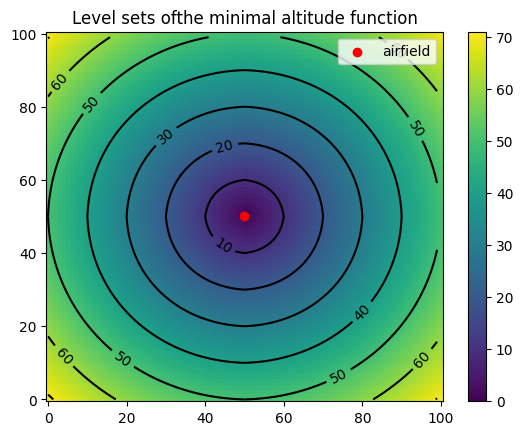

In [5]:
# plot the minimal altitude surface
# we plot it both showing its level sets (i.e. curves with constant altitude), and using the contiuous color range.
x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
plt.pcolormesh(xx,yy,min_altitude)
plt.colorbar()
CS=plt.contour(min_altitude,levels=[10,20,30,40,50,60,70,80,90,100],colors='black')
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield")
plt.legend()
plt.title("Level sets ofthe minimal altitude function")

Text(0.5, 0.92, 'Gliding cone')

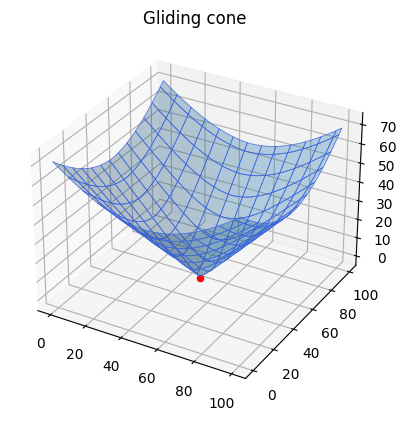

In [6]:
#3D surface representing the gliding cone.
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx,yy, min_altitude, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3,label="minimal altitude")
ax.scatter(airfield_idx[1],airfield_idx[0],0,color="red",label="airfield")
plt.title("Gliding cone")

### Checking correctness
At least in this simple case wothout obstacles we alreay know the exact solution. We can check how well our numerical solver approximates the true solution.
The following plot shows the percentual error of our solution (e.). The higher the worse)

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/14262415.py:6: RuntimeWarning: invalid value encountered in divide
  CS=plt.contour(100*(min_altitude-true_dist_mat)/true_dist_mat,levels=[0.1,0.5,1,3],colors='black')


Text(0.5, 1.0, 'Percentage error in numerical solution')

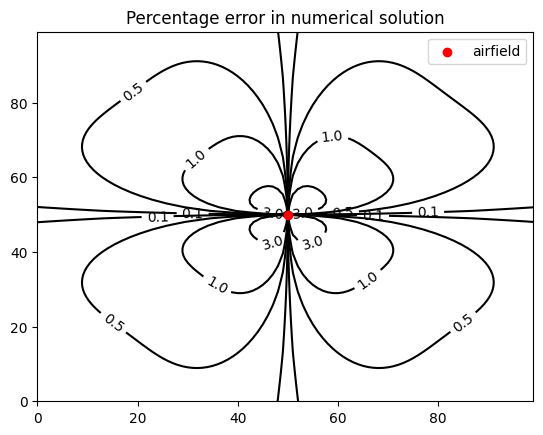

In [7]:
#check that the solver is working using  the true distance matrix
true_dist_mat=np.zeros(solver.velocity.npts[:-1])
true_dist_mat=euclidean_distance_matrix(airfield_idx[0],airfield_idx[1],H,W,hx,hy)

# relative error contour plot
CS=plt.contour(100*(min_altitude-true_dist_mat)/true_dist_mat,levels=[0.1,0.5,1,3],colors='black')
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield",zorder=2)
plt.legend()
plt.title("Percentage error in numerical solution")

The result is that on most of the domain the altitude we obtained numerically is within $1\%$ of the true altitude value. Moreover, moving further from the airfield this error decreases.

## Re-entry paths. 
Once we computed the minimal altitude profile for re entry, we can also compute the re entry paths.
These are paths are obtained by taking the gradient of the minimal altitude function at every point in space, and then integrating the resulting vector field.
As expected, in this simpel setting the optimal re-entry paths are straight lines pointing towards the airfield.

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/1278564793.py:5: RuntimeWarning: invalid value encountered in divide
  grad_V[0]=grad_V[0]/grad_norm
/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/1278564793.py:6: RuntimeWarning: invalid value encountered in divide
  grad_V[1]=grad_V[1]/grad_norm


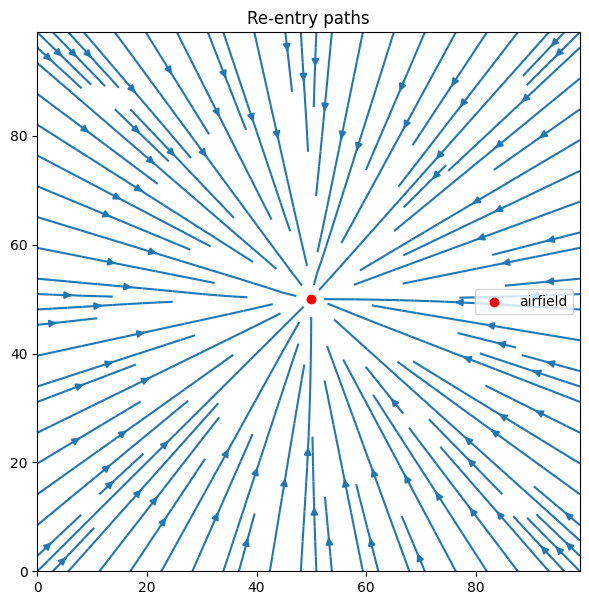

In [8]:
plt.figure(figsize=(7,7))
V=solver.traveltime.values[...,0]
grad_V=np.array(np.gradient(V))
grad_norm=np.sqrt(grad_V[0]**2+grad_V[1]**2)
grad_V[0]=grad_V[0]/grad_norm
grad_V[1]=grad_V[1]/grad_norm
x=np.arange(0,W,hx)
y=np.arange(0,H,hy)
xx,yy=np.meshgrid(x,y)
plt.streamplot(xx,yy,-grad_V[1],-grad_V[0],density=1.2)
plt.title("Re-entry paths")
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield",zorder=2)
plt.legend()

# Single peak
In this section we look at how terrain modifies our gliding cone. A simple example to start with is that of a single mountain with flat land around it.

In [9]:
xx,yy=np.meshgrid(np.arange(0,W,hx,dtype=np.intc),np.arange(0,H,hy,dtype=np.intc))
center=[50,50]

In [10]:
H=100
W=100
hx=1
hy=1
origin_coords=(0,0,0)
# Instantiate EikonalSolver object using Cartesian coordinates.
solver = glikonal.EikonalSolver(coord_sys="cartesian")
# Set the coordinates of the lower bounds of the computational grid.
# For Cartesian coordinates this is x_min, y_min, z_min.
# In this example, the origin is the lower bound of the computation grid.
solver.velocity.min_coords = origin_coords
solver.elevation.min_coords = origin_coords

# Set the interval between nodes of the computational grid.
# For Cartesian coordinates this is dx, dy, dz.
# In this example the nodes are separated by 1 m in in each direction.
solver.velocity.node_intervals = hx, hy, 1
solver.elevation.node_intervals = hx, hy, 1

# Set the number of nodes in the computational grid.
# For Cartesian coordinates this is nx, ny, nz.
# This is a 2D example, so we only want one node in the z direction.
solver.velocity.npts = W, H, 1
solver.elevation.npts = W, H, 1

# Set the glide ratio to 1 for simplicity
glide_ratio=1
solver.velocity.values = glide_ratio*np.ones(solver.velocity.npts)

In [11]:
#set the elevation profile
elevation_profile=160*np.exp(-((xx-center[0])**2+(yy-center[1])**2)/180) #set the elevation profile
solver.elevation.values[...,0] = elevation_profile
airfield_idx= 50,0,0 #(y,x,z)
# Set the altitude at the airfield node to 0.
solver.traveltime.values[airfield_idx] = 0
# Set the unknown flag for the source node to False.
# This is an FMM state variable indicating which values are completely
# unknown. Setting it to False indicates that the node has a tentative value
# assigned to it. In this case, the tentative value happens to be the true,
# final value.
solver.unknown[airfield_idx] = False
# Push the index of the source node onto the narrow-band heap.
solver.trial.push(*airfield_idx)
# Solve the system.
solver.solve()

1

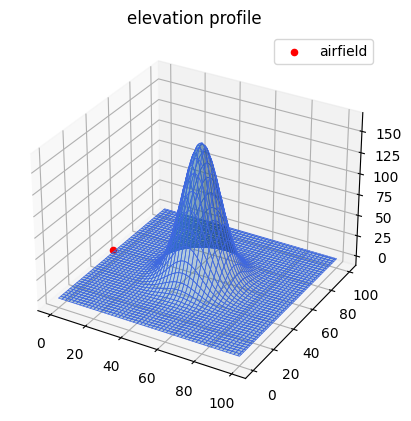

In [12]:
#3D surface representing the gliding cone.
x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx,yy, elevation_profile, edgecolor='royalblue', lw=0.5, rstride=2, cstride=2,alpha=0.3)
ax.scatter(airfield_idx[1],airfield_idx[0],2,c="red",label="airfield",zorder=1)
plt.title("elevation profile")
plt.legend()

Now plot the solution (i.e. the minimal altitude profile).
The minimal altitude level sets are plotted in white, while the background represents the elevation profile.
One sees how the moving front "wraps" around the mountain.

Text(0.5, 1.0, 'Minimal altitude lines (white), plotted on top of the elevaton profile')

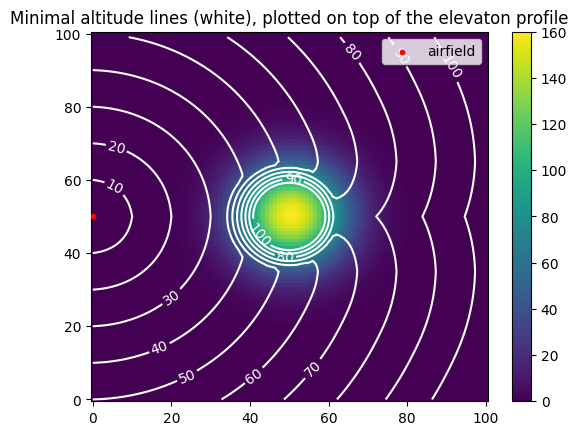

In [13]:
CS=plt.contour(solver.traveltime.values[...,0],levels=[10,20,30,40,50,60,70,80,90,100],colors="white")
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield",s=10,zorder=3)
plt.pcolormesh(xx,yy,elevation_profile)
plt.legend()
plt.colorbar()
plt.title("Minimal altitude lines (white), plotted on top of the elevaton profile")

Text(0.5, 0.92, 'Minimal altitude (green) and elevation profile (blue)')

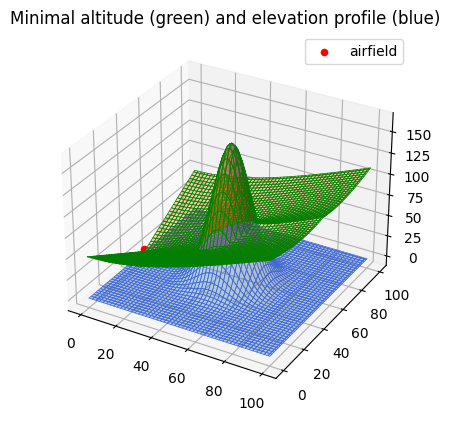

In [14]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx,yy, elevation_profile, edgecolor='royalblue', lw=0.5, rstride=2, cstride=2,alpha=0.3)
ax.plot_surface(xx,yy, solver.traveltime.values[...,0], edgecolor='green', lw=0.5, rstride=2, cstride=2,alpha=0.3)

ax.scatter(airfield_idx[1],airfield_idx[0],4,c="red",label="airfield",zorder=100)
plt.title("elevation profile")
plt.legend()
plt.title("Minimal altitude (green) and elevation profile (blue)")

Next we compute the re-entry paths using the same method as in the previous example (i.e. we take the gradient of the minimal altitude function and we intrgrate vit to find the curves).
At this point we should empahsize that the paths computed by the algorithm are not necessarily optimal. This means that, for a given starting point, there could be a different path that results in a smaller loss of altitude. 


The algorihtm instead produces paths that are **safe**. This means that:
1. All proposed paths will  avoid terrain
2. All proposed paths satify the glide ratio constraint (i.e. at all points of the path the maximum glide ratio required is the one given to the algorithm).

### It is important to understand this is still a relatively new algorithm and there is no guarantee that all of its outputs are correct. Hence don't trust this thing blindly. Since this algorithm can be used in safety critical applications, let us report here the disclaimer also contained in the license file. 


 15. Disclaimer of Warranty.

  THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY
APPLICABLE LAW.  EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT
HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM "AS IS" WITHOUT WARRANTY
OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE.  THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE PROGRAM
IS WITH YOU.  SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF
ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

  16. Limitation of Liability.

  IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING
WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MODIFIES AND/OR CONVEYS
THE PROGRAM AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY
GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE
USE OR INABILITY TO USE THE PROGRAM (INCLUDING BUT NOT LIMITED TO LOSS OF
DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD
PARTIES OR A FAILURE OF THE PROGRAM TO OPERATE WITH ANY OTHER PROGRAMS),
EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF
SUCH DAMAGES.

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/2760958167.py:5: RuntimeWarning: invalid value encountered in divide
  grad_V[0]=grad_V[0]/grad_norm
/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/2760958167.py:6: RuntimeWarning: invalid value encountered in divide
  grad_V[1]=grad_V[1]/grad_norm


Text(0.5, 1.0, 'Re-entry paths plotted on top of the elevation profile')

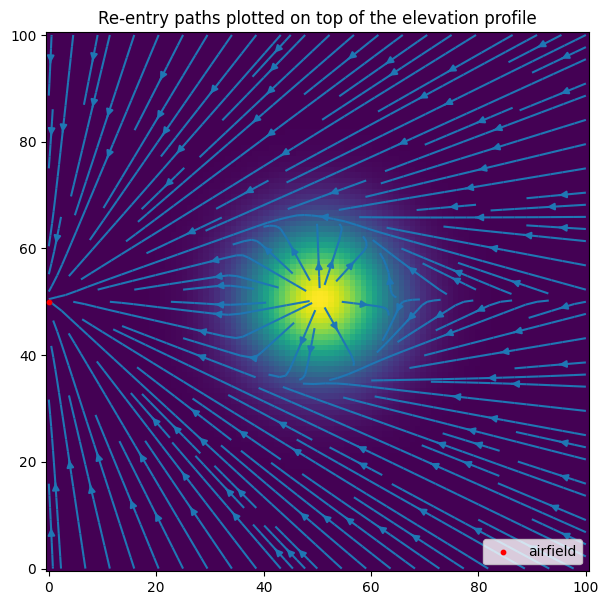

In [15]:
plt.figure(figsize=(7,7))
V=solver.traveltime.values[...,0]
grad_V=np.gradient(V)
grad_norm=np.sqrt(grad_V[0]**2+grad_V[1]**2)
grad_V[0]=grad_V[0]/grad_norm
grad_V[1]=grad_V[1]/grad_norm
plt.pcolormesh(xx,yy,elevation_profile)
plt.streamplot(xx,yy,-grad_V[1],-grad_V[0],density=1.5)
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield",s=10,zorder=3)
plt.legend()
plt.title("Re-entry paths plotted on top of the elevation profile")

# Mountain range with two saddles (cols)
Here we simulate the landscape of a mountain with two saddles. The saddles represent the best place to pass the mountain range.
The two saddles have different height, with one saddle higher than the other.


In [16]:
xx,yy=np.meshgrid(np.arange(0,W,hx,dtype=np.intc),np.arange(0,H,hy,dtype=np.intc))
peak_x=40
elevation_profile=85*np.exp(-(xx-peak_x)**2/40)
saddle_1_y=20
saddle_1_strength=30 #the higher the strength the lower the top of the saddle
saddle_2_y=80
saddle_2_strength=40
elevation_profile=np.maximum(0,elevation_profile-saddle_1_strength*np.exp(-(yy-saddle_1_y)**2/10)-saddle_2_strength*np.exp(-(yy-saddle_2_y)**2/10))

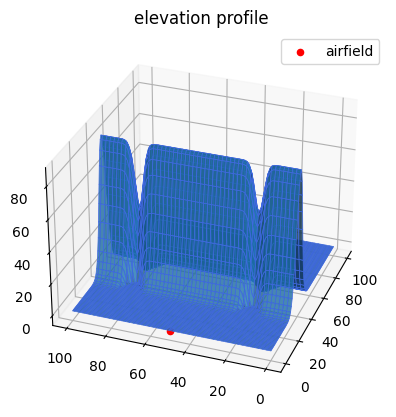

In [17]:
#3D surface representing the gliding cone.
x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx,yy, elevation_profile, edgecolor='royalblue', lw=0.5, rstride=2, cstride=1,alpha=0.8)
ax.scatter(airfield_idx[1],airfield_idx[0],0,c="red",label="airfield",zorder=0)
ax.view_init(30,200)
plt.title("elevation profile")
plt.legend()

In [18]:
H=100
W=100
hx=1
hy=1
origin_coords=(0,0,0)
# Instantiate EikonalSolver object using Cartesian coordinates.
solver = glikonal.EikonalSolver(coord_sys="cartesian")
# Set the coordinates of the lower bounds of the computational grid.
# For Cartesian coordinates this is x_min, y_min, z_min.
# In this example, the origin is the lower bound of the computation grid.
solver.velocity.min_coords = origin_coords
solver.elevation.min_coords = origin_coords

# Set the interval between nodes of the computational grid.
# For Cartesian coordinates this is dx, dy, dz.
# In this example the nodes are separated by 1 m in in each direction.
solver.velocity.node_intervals = hx, hy, 1
solver.elevation.node_intervals = hx, hy, 1

# Set the number of nodes in the computational grid.
# For Cartesian coordinates this is nx, ny, nz.
# This is a 2D example, so we only want one node in the z direction.
solver.velocity.npts = W, H, 1
solver.elevation.npts = W, H, 1

#set glide ration to 1 for simplicity
glide_ratio=1
solver.velocity.values = glide_ratio*np.ones(solver.velocity.npts)

In [19]:
#set the elevation profile
solver.elevation.values[...,0] = elevation_profile
airfield_idx= 50,0,0
# Set the traveltime at the source node to 0.
solver.traveltime.values[airfield_idx] = 0
# Set the unknown flag for the source node to False.
# This is an FMM state variable indicating which values are completely
# unknown. Setting it to False indicates that the node has a tentative value
# assigned to it. In this case, the tentative value happens to be the true,
# final value.
solver.unknown[airfield_idx] = False
# Push the index of the source node onto the narrow-band heap.
solver.trial.push(*airfield_idx)
# Solve the system.
solver.solve()

1

Text(0.5, 1.0, 'Minimal altitude lines (white) plotted on top of the elevation profile')

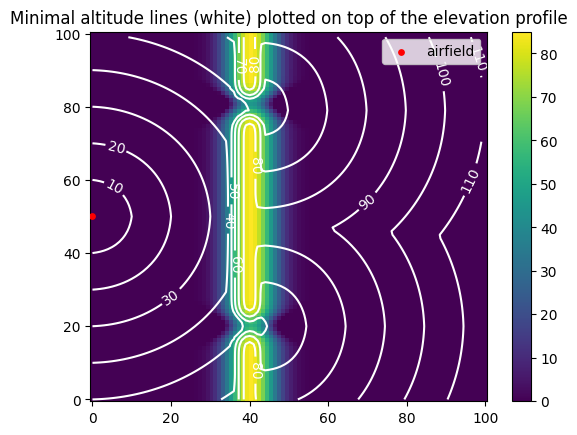

In [20]:
CS=plt.contour(solver.traveltime.values[...,0],levels=[10,20,30,40,50,60,70,80,90,100,110,120],colors="white")
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
plt.pcolormesh(xx,yy,elevation_profile)
plt.colorbar()
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield",s=15,zorder=3)
plt.legend()
plt.title("Minimal altitude lines (white) plotted on top of the elevation profile")

Text(0.5, 0.92, 'Minimal altitude (green) and elevation profile (blue)')

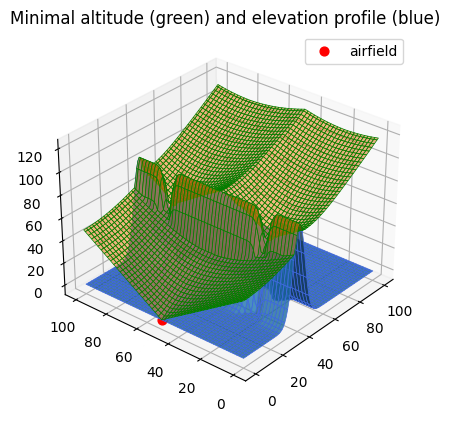

In [21]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx,yy, elevation_profile, edgecolor='royalblue', lw=0.5, rstride=2, cstride=2,alpha=0.8)
ax.plot_surface(xx,yy, solver.traveltime.values[...,0], edgecolor='green', lw=0.5, rstride=2, cstride=2,alpha=0.5)
ax.scatter(airfield_idx[1],airfield_idx[0],0,c="red",label="airfield",s=40,zorder=0)
ax.view_init(30,220)

plt.title("elevation profile")
plt.legend()
plt.title("Minimal altitude (green) and elevation profile (blue)")

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/3683476300.py:6: RuntimeWarning: invalid value encountered in divide
  grad_V[0]=grad_V[0]/grad_norm
/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_36847/3683476300.py:7: RuntimeWarning: invalid value encountered in divide
  grad_V[1]=grad_V[1]/grad_norm


Text(0.5, 1.0, 'Re-entry paths plotted on top of the elevation profile')

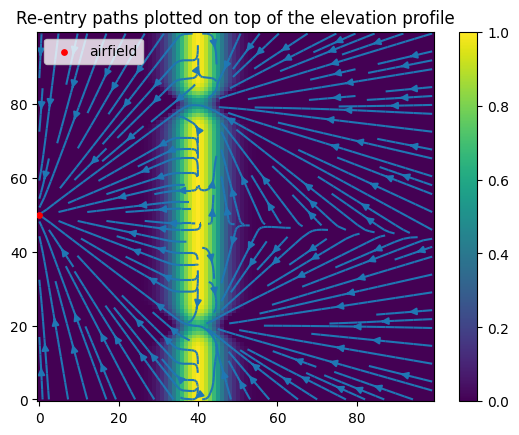

In [22]:
plt.figure()
downsample=1 #downsample the grid to help visualizing the vector field
V=solver.traveltime.values[...,0]
grad_V=np.gradient(V)
grad_norm=np.sqrt(grad_V[0]**2+grad_V[1]**2)
grad_V[0]=grad_V[0]/grad_norm
grad_V[1]=grad_V[1]/grad_norm
x=np.arange(0,W,hx)
y=np.arange(0,H,hy)
xx,yy=np.meshgrid(x,y)
plt.pcolormesh(xx,yy,elevation_profile)
plt.streamplot(xx,yy,-grad_V[1],-grad_V[0],density=1.4)
plt.scatter(airfield_idx[1],airfield_idx[0],c="red",label="airfield",s=15,zorder=3)
plt.legend()
plt.colorbar()
plt.title("Re-entry paths plotted on top of the elevation profile")

In this example it is interesting to notice that if one is on the right side of the mountain range and must come back to the airport, then depending on his position there is an optimal choice for the saddle to use. In other words each saddle has a certain basin of attraction. This algorithm then allows to pick the most convenient saddle given the starting point.